In this notebook, we use the FoldX feature set (13 features) to predict soluble expression (0=no, 1=yes) for 128 samples. Three classifiers are tried: logistic regression, SVM, and random forest 

In [85]:
%matplotlib inline 
import pandas 
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt 
from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegressionCV

my_classifiers = []

In [52]:
df = pandas.read_csv( 'feature_sets/expression_foldx.csv', index_col=0 ) 

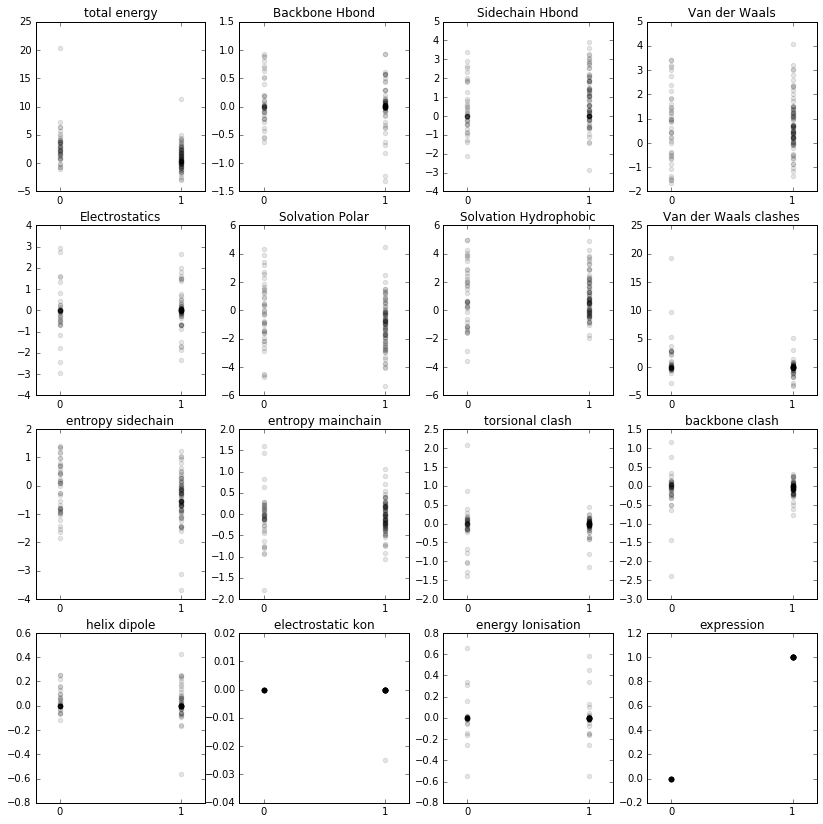

In [103]:
# %matplotlib inline 
# import matplotlib.pyplot as plt 

plt.figure( figsize=( 14, 14 ) ) 

for i, feature in enumerate( df.columns ):
    plt.subplot( 4, 4, i + 1 ) 
    plt.scatter( df.expression, df[ feature ], c='k', alpha=0.1 ) #, c=df.expression, cmap='Blues', vmin=-0.5 ) 
    plt.title( feature ) 
    plt.xticks( [ 0, 1 ], [ 0, 1 ] ) 

plt.show()

**FoldX feature set**: individual feature versus expression (yes/no)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139a4eb10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x142cf8210>]], dtype=object)

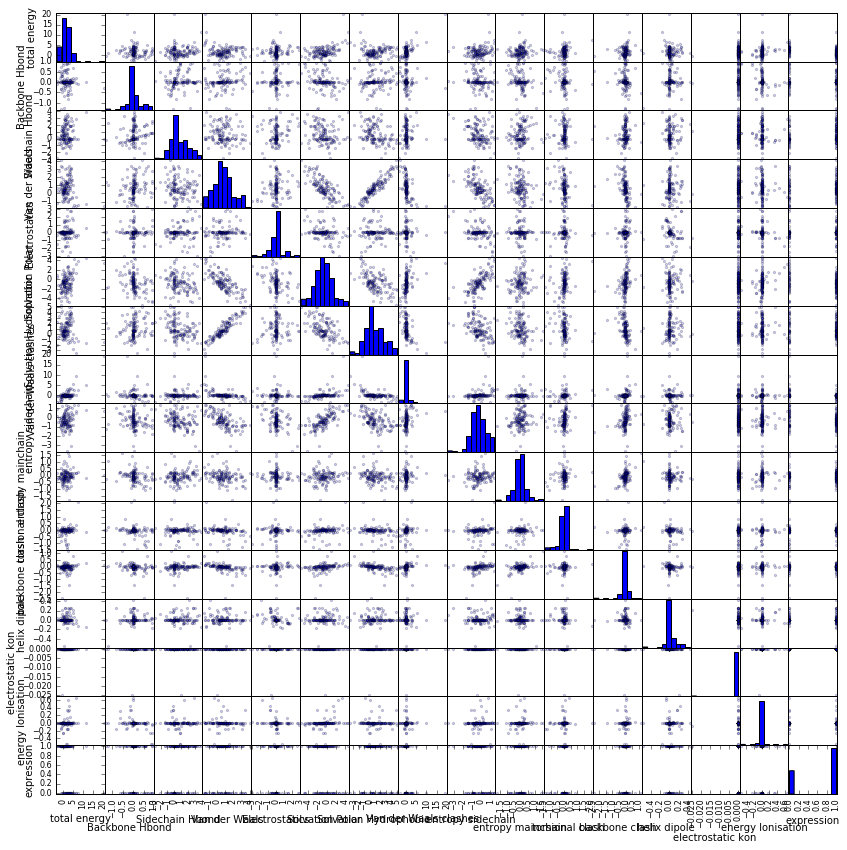

In [104]:
scatter_matrix(df, alpha=0.2, figsize=(14, 14) ) #, diagonal='kde')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c366450>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ce31590>], dtype=object)

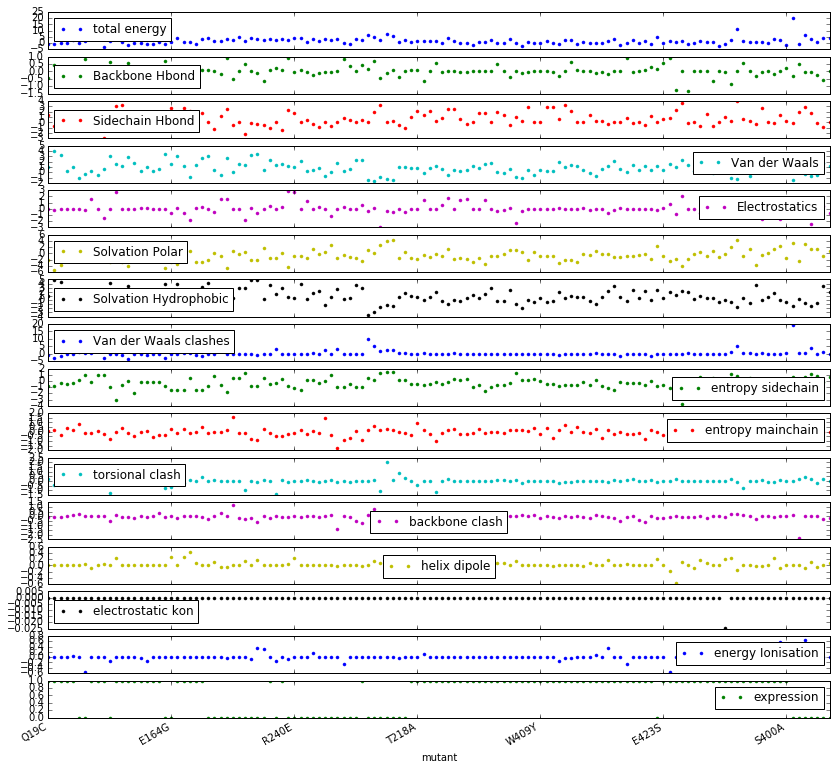

In [63]:
# sequence-based view of features 
df.plot(subplots=True, style='.', figsize=(14,14))

In [105]:
# unbalanced classes 
my_list = list( y ) 
print my_list.count( 0 ), 'samples of class 0'
print my_list.count( 1 ), 'samples of class 1'

43 samples of class 0
85 samples of class 1


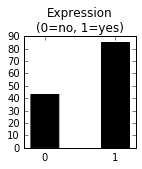

In [106]:
plt.figure( figsize=( 2,2 ) ) 
plt.hist( y, bins=2, color='k', rwidth=0.4 )
plt.xticks( [ .25, .75 ], [ '0', '1' ] ) 
plt.title( 'Expression\n(0=no, 1=yes)' ) 

In [56]:
# scale features and separate into predictors

scl = preprocessing.RobustScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1:].as_matrix().ravel()

print X.shape
print y.shape

(128, 15)
(128,)


In [57]:
# Split the dataset in two equal parts to be used to train and test 3 classifiers below 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

### Begin the classifiers

             precision    recall  f1-score   support

          0       0.64      0.38      0.47        24
          1       0.70      0.88      0.78        40

avg / total       0.68      0.69      0.66        64



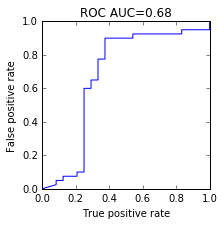

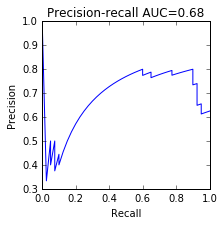

In [109]:
# random forest

from sklearn.naive_bayes import GaussianNB

param_grid = [
    { 
#         'rf__criterion': [ 'entropy', 'gini' ], 
#         'rf__n_estimators': [ 10, 50 ], 
#         'rf__max_features': [ 1, 2, 'sqrt', None ], 
#         'rf__max_depth': [ 2, 3, 6 ], 
#         'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print classification_report( y_true, y_pred )

y_desc = clf.predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
# feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
# w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
# w.set_index( 'feature', inplace=True ) 
# w.sort_values( by='importance', ascending=False )

In [84]:
# random forest

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

             precision    recall  f1-score   support

          0       0.56      0.38      0.45        24
          1       0.69      0.82      0.75        40

avg / total       0.64      0.66      0.64        64



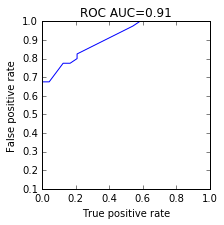

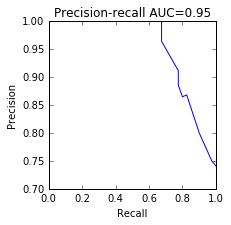

,importance
feature,
entropy sidechain,0.145070
backbone clash,0.116692
Van der Waals clashes,0.091075
Electrostatics,0.088281
entropy mainchain,0.085278
electrostatic kon,0.081438
total energy,0.073644
Sidechain Hbond,0.053724
helix dipole,0.050602


In [86]:
# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print classification_report( y_true, y_pred )

y_desc = clf.best_estimator_.named_steps['rf'].predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'svm__C': 3, 'pca__n_components': 10, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}

Grid scores on development set:

0.324 (+/-0.415) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.672 (+/-0.382) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.324 (+/-0.415) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.672 (+/-0.382) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.567 (+/-0.275) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__w

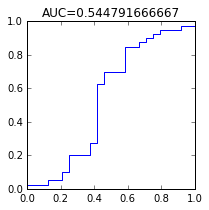

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'svm__C': 0.1, 'pca__n_components': 10, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}

Grid scores on development set:

0.531 (+/-0.415) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.719 (+/-0.223) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.531 (+/-0.415) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.719 (+/-0.223) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.656 (+/-0.262) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__wh

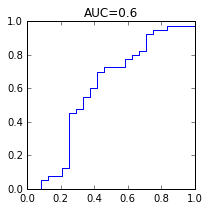

In [59]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

Best parameters found on training set
{'logit__class_weight': 'balanced'}
Grid scores on training set
0.734 (±0.307) for {'logit__class_weight': 'balanced'}
0.688 (±0.208) for {'logit__class_weight': None}
Detailed classification report
             precision    recall  f1-score   support

          0       0.50      0.50      0.50        24
          1       0.70      0.70      0.70        40

avg / total       0.62      0.62      0.62        64



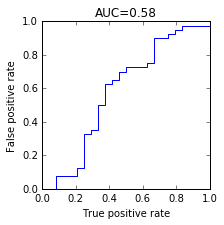

,importance
feature,
Sidechain Hbond,1.011874
electrostatic kon,0.494352
backbone clash,0.358021
Backbone Hbond,0.330702
torsional clash,0.210541
Electrostatics,0.024361
helix dipole,-0.017148
energy Ionisation,-0.023385
Solvation Polar,-0.223779


In [60]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced', None ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )